In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


In [13]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

3 Physical GPUs, 3 Logical GPUs


In [14]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [15]:
np.random.seed(42)
tf.random.set_seed(8)


In [16]:
def build_model(p_i):
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "track")
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "tower")
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(3, activation = 'softmax')
    ])
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    x_out = keras.layers.Multiply()([x_1, x_2])
    model = keras.Model(         
    inputs=[input_1, input_2],
    outputs=x_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [17]:
def build_model_clustering(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [18]:
#Preparing samples
n_samples = 3
os.chdir('/home/manhducnmd/manhducnmd/Delphes-3.5.0')    
sample_1_1_train_track = np.load(f'wboson_region_1_track.npy')
sample_1_1_train_tower = np.load(f'wboson_region_1_tower.npy')
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_1_1_train_track)[0]).reshape(np.shape(sample_1_1_train_track)[0],n_samples)

sample_1_2_train_track = np.load(f'zboson_region_1_track.npy')
sample_1_2_train_tower = np.load(f'zboson_region_1_tower.npy')
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_1_2_train_track)[0]).reshape(np.shape(sample_1_2_train_track)[0],n_samples)

sample_1_3_train_track = np.load(f'zprimeboson_region_1_track.npy')
sample_1_3_train_tower = np.load(f'zprimeboson_region_1_tower.npy')
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_1_3_train_track)[0]).reshape(np.shape(sample_1_3_train_track)[0],n_samples)

sample_2_1_train_track = np.load(f'wboson_region_2_track.npy')
sample_2_1_train_tower = np.load(f'wboson_region_2_tower.npy')
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_2_1_train_track)[0]).reshape(np.shape(sample_2_1_train_track)[0],n_samples)


sample_2_2_train_track = np.load(f'zboson_region_2_track.npy')
sample_2_2_train_tower = np.load(f'zboson_region_2_tower.npy')
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_2_2_train_track)[0]).reshape(np.shape(sample_2_2_train_track)[0],n_samples)


sample_2_3_train_track = np.load(f'zprimeboson_region_2_track.npy')
sample_2_3_train_tower = np.load(f'zprimeboson_region_2_tower.npy')
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_2_3_train_track)[0]).reshape(np.shape(sample_2_3_train_track)[0],n_samples)


sample_3_1_train_track = np.load(f'wboson_region_3_track.npy')
sample_3_1_train_tower = np.load(f'wboson_region_3_tower.npy')
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_3_1_train_track)[0]).reshape(np.shape(sample_3_1_train_track)[0],n_samples)


sample_3_2_train_track = np.load(f'zboson_region_2_track.npy')
sample_3_2_train_tower = np.load(f'zboson_region_2_tower.npy')
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_3_2_train_track)[0]).reshape(np.shape(sample_3_2_train_track)[0],n_samples)


sample_3_3_train_track = np.load(f'zprimeboson_region_2_track.npy')
sample_3_3_train_tower = np.load(f'zprimeboson_region_2_tower.npy')
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_3_3_train_track)[0]).reshape(np.shape(sample_3_3_train_track)[0],n_samples)



In [19]:
rng = np.random.default_rng()
x_1_track = np.concatenate((sample_1_1_train_track, sample_1_2_train_track, sample_1_3_train_track))
x_1_tower = np.concatenate((sample_1_1_train_tower, sample_1_2_train_tower, sample_1_3_train_tower))
y_1 = np.tile(np.array([1., 0., 0.]), 
        np.shape(x_1_track)[0]).reshape(np.shape(x_1_track)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                                true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_1_track)[0])

x_shuffle_1_track = x_1_track[indices_1]
x_shuffle_1_tower = x_1_tower[indices_1]

y_shuffle_1 = y_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_2_track = np.concatenate((sample_2_1_train_track, sample_2_2_train_track, sample_2_3_train_track))
x_2_tower = np.concatenate((sample_2_1_train_tower, sample_2_2_train_tower, sample_2_3_train_tower))
y_2 = np.tile(np.array([0., 1., 0.]), 
        np.shape(x_2_track)[0]).reshape(np.shape(x_2_track)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                                true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_2_track)[0])

x_shuffle_2_track = x_2_track[indices_2]
x_shuffle_2_tower = x_2_tower[indices_2]

y_shuffle_2 = y_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_3_track = np.concatenate((sample_3_1_train_track, sample_3_2_train_track, sample_3_3_train_track))
x_3_tower = np.concatenate((sample_3_1_train_tower, sample_3_2_train_tower, sample_3_3_train_tower))
y_3 = np.tile(np.array([0., 0., 1.]), 
        np.shape(x_3_track)[0]).reshape(np.shape(x_3_track)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                                true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_3_track)[0])

x_shuffle_3_track = x_3_track[indices_3]
x_shuffle_3_tower = x_3_tower[indices_3]

y_shuffle_3 = y_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]

In [23]:

x_track = np.concatenate((x_shuffle_1_track, x_shuffle_2_track, x_shuffle_3_track))
x_tower = np.concatenate((x_shuffle_1_tower, x_shuffle_2_tower, x_shuffle_3_tower))
y = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

indices_shuffle = rng.permutation(np.shape(y)[0])

x_track = x_track[indices_shuffle]
x_tower = x_tower[indices_shuffle]
y = y[indices_shuffle]

true_label = true_label[indices_shuffle]

from sklearn.model_selection import train_test_split
x_track_train, x_track_test, x_tower_train, x_tower_test, y_train, y_test, true_label_train, true_label_test = train_test_split(
    x_track, x_tower, y, true_label, test_size=0.2, random_state=42)

model = build_model(x_track.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
history = model.fit([x_track_train, x_tower_train], y_train, validation_split = 0.2, epochs=200, batch_size=1024, verbose=1, 
                    callbacks=[
                                early_stopping,
                                   ])

Epoch 1/200
21/21 [==============================] - 2s 76ms/step - loss: 1.0585 - accuracy: 0.3840 - val_loss: 1.0563 - val_accuracy: 0.3793
Epoch 2/200
21/21 [==============================] - 1s 68ms/step - loss: 1.0401 - accuracy: 0.3966 - val_loss: 1.0529 - val_accuracy: 0.3889
Epoch 3/200
21/21 [==============================] - 1s 69ms/step - loss: 1.0297 - accuracy: 0.4228 - val_loss: 1.0299 - val_accuracy: 0.4014
Epoch 4/200
21/21 [==============================] - 1s 66ms/step - loss: 1.0123 - accuracy: 0.4715 - val_loss: 1.0106 - val_accuracy: 0.4615
Epoch 5/200
21/21 [==============================] - 1s 67ms/step - loss: 0.9869 - accuracy: 0.5139 - val_loss: 0.9843 - val_accuracy: 0.5058
Epoch 6/200
21/21 [==============================] - 1s 65ms/step - loss: 0.9661 - accuracy: 0.5310 - val_loss: 0.9875 - val_accuracy: 0.4935
Epoch 7/200
21/21 [==============================] - 1s 68ms/step - loss: 0.9595 - accuracy: 0.5322 - val_loss: 0.9587 - val_accuracy: 0.5095
Epoch 

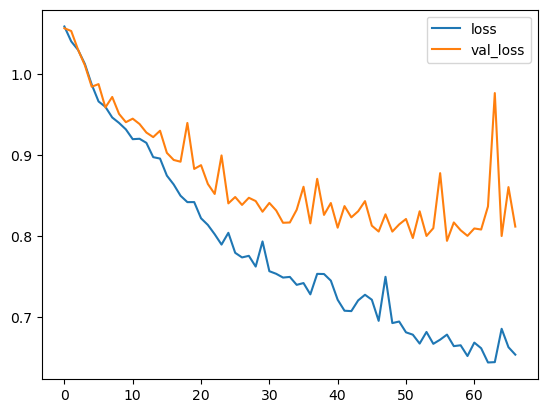

In [24]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

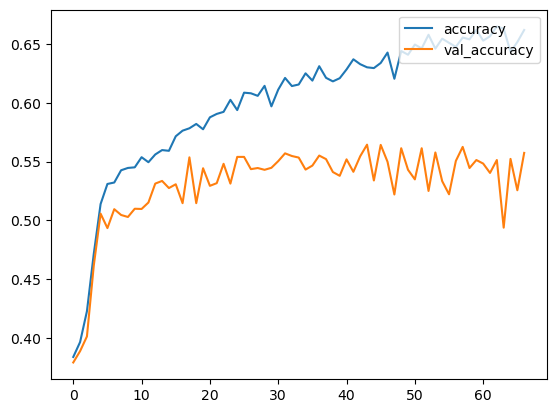

In [26]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [28]:
#Evaluate on the true labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], true_label_test)

 10/207 [>.............................] - ETA: 1s - loss: 1.5534 - accuracy: 0.4781

207/207 [==============================] - 1s 6ms/step - loss: 1.6355 - accuracy: 0.4214


In [29]:
#Evaluate on the training labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], y_test)
print(accuracy)

207/207 [==============================] - 1s 7ms/step - loss: 0.8182 - accuracy: 0.5500
0.5499924421310425
